## Import modules and functions

In [1]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path
%matplotlib inline
def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio
import pims
from skimage.measure import regionprops

## Define directory of images

In [2]:
expdir='/Volumes/ukps-all$/user/tdanko/Imaging/03_Collab/2020_Clara/All files/'

protein="TNR" #TNR,Agg,WFA,HABP

## Make a dictionary to store filenames and spots

In [3]:
results_vglut = {"filename":[],
          "exp condition":[],
           "Manual vglut spots mask":[],
          }
results_syt1 = {"filename":[],
          "exp condition":[],
           "Manual syt spots mask":[],
          }
           
path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    if filelist[i].endswith(".tif"):
        if ("ignore" in str(filelist[i]))==False:
            if ("icy" in str(filelist[i]))==False:
                if ("Secondary" in str(filelist[i]))==False:
                    if "VGLUT1" in str(filelist[i]):
                        if "\\" in str(filelist[i]):
                            #print(7)
                            if (('/').join(filelist[i].split('\\')[:-1])+'\\\\'+filelist[i][:-12].split('\\')[-1] in str(results_vglut["filename"]))==False:
                                print(filelist[i])
                                results_vglut["filename"].append(filelist[i])
                                results_vglut["exp condition"].append(filelist[i][:-12].split('/')[-2])
                        elif (str(filelist[i][:-12]) not in str(results_vglut["filename"]))==True:
                            #print(8)
                            results_vglut["filename"].append(filelist[i])
                            results_vglut["exp condition"].append(filelist[i][:-12].split('/')[-2])


for i in range(0,len(filelist)):
    if filelist[i].endswith(".tif"): 
        if ("ignore" in str(filelist[i]))==False:
            if ("icy" in str(filelist[i]))==False:
                if "SYT1" in str(filelist[i]):
                    if "\\" in str(filelist[i]):
                        #print(7)
                        if (('/').join(filelist[i].split('\\')[:-1])+'\\\\'+filelist[i][:-12].split('\\')[-1] in str(results_syt1["filename"]))==False:
                            print(filelist[i])
                            results_syt1["filename"].append(filelist[i])
                            results_syt1["exp condition"].append(filelist[i][:-12].split('/')[-2])
                    elif (str(filelist[i][:-12]) not in str(results_syt1["filename"]))==True:
                        #print(8)
                        results_syt1["filename"].append(filelist[i])
                        results_syt1["exp condition"].append(filelist[i][:-12].split('/')[-2])

## Display a random image

Image name: stacked__105_HPN20DIV_Phalloidin-AF405_Homer-gp-AF488_ERGIC-rbt-AF594_Vglut1-Star635P_PFA_old_series9.tif
Experimental condition: ERGIC


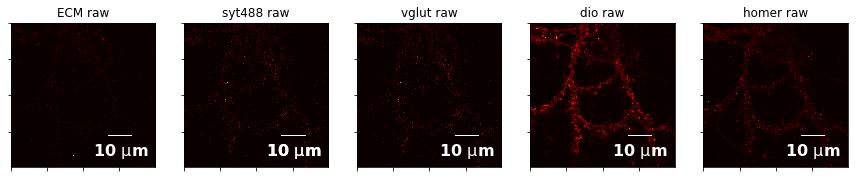

In [4]:
randomno=np.random.randint(1,len(results_vglut["filename"]))

full_image=pims.open(results_vglut["filename"][randomno])

print("Image name:",results_vglut["filename"][randomno].split('/')[-1])
print("Experimental condition:",results_vglut["exp condition"][randomno])

if len(full_image)==7:
    ecm_image=full_image[5] #channel of changing protein (need to subtract 1)
    syt_image=full_image[6]
    vglut_image=full_image[6]
    homer=full_image[3]
    dio=full_image[4]
else:
    ecm_image=full_image[3] #channel of changing protein (need to subtract 1)
    syt_image=full_image[1]
    vglut_image=full_image[1]
    homer=full_image[8]
    dio=full_image[6]

figure=plt.figure(figsize=(15,15))
figure.add_subplot(151)
plt.imshow(ecm_image,interpolation='none',cmap='hot')
plt.title('ECM raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(30, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)


figure.add_subplot(152)
plt.imshow(syt_image,interpolation='none',cmap='hot')
plt.title('syt488 raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(30, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    
plt.gca().add_artist(scalebar)

plt.gca().add_artist(scalebar)

figure.add_subplot(153)
plt.imshow(vglut_image,interpolation='none',cmap='hot')
plt.title('vglut raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(30, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    
plt.gca().add_artist(scalebar)

figure.add_subplot(154)
plt.imshow(dio,interpolation='none',cmap='hot')
plt.title('dio raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(30, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    
plt.gca().add_artist(scalebar)

figure.add_subplot(155)
plt.imshow(homer,interpolation='none',cmap='hot')
plt.title('homer raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(30, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    
plt.gca().add_artist(scalebar)

## Load spots made in Python widget

In [5]:
for image in range(0,len(results_vglut["filename"])):
    results_vglut["Manual vglut spots mask"].append(np.load(results_vglut["filename"][image]+'_vglut_spots_mask_conservative.npy'))

## Sanity check - see that spots are loaded correctly

213


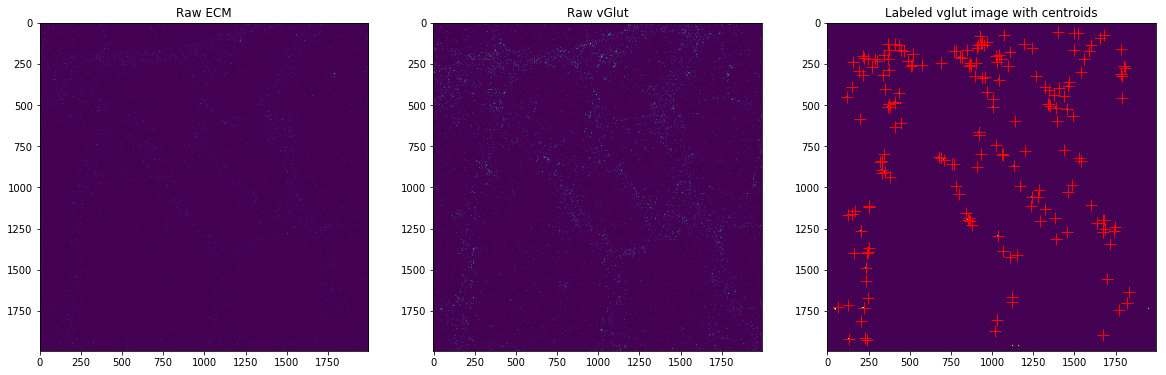

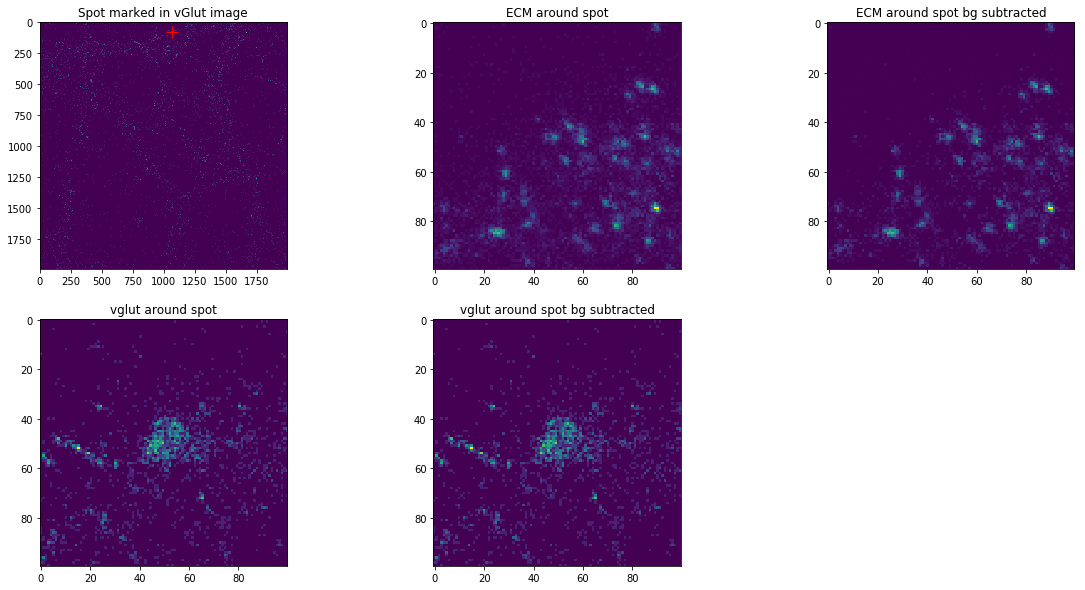

In [11]:
randomno=np.random.randint(1,len(results_vglut["filename"]))


ecm_distribution_around_synapses={"filename":[],
                                  "exp condition":[],
                                  "ecm_around_single_spot":[],
                                  "ecm_around_single_spot_mean_intensity":[],
                                  "original_synapse_at_single_spot":[],
                                  "mean_intensty_original_synapse":[],
                                  "ecm_around_single_spot bg subtracted":[],
                                  "ecm_around_single_spot_mean_intensity bg subtracted":[],
                                  "original_synapse_at_single_spot bg subtracted":[],
                                  "mean_intensty_original_synapse bg subtracted":[]
                                 }

full_image=pims.open(results_vglut["filename"][randomno])


if len(full_image)==7:
    ecm_image=full_image[5] #channel of changing protein (need to subtract 1)
    syt_image=full_image[6]
    vglut_image=full_image[6]
    homer=full_image[3]
    dio=full_image[4]
else:
    ecm_image=full_image[3] #channel of changing protein (need to subtract 1)
    syt_image=full_image[1]
    vglut_image=full_image[1]
    homer=full_image[8]
    dio=full_image[6]

synapse_image=vglut_image
#label images
spots_mask=results_vglut["Manual vglut spots mask"][randomno]
spots_labeled, cc_num=ndi.label(spots_mask)
#cut out ecm image 4microns around each spot - 200pixels
print(cc_num)
regions = regionprops(spots_labeled)
#fig, ax = plt.subplots(figsize=(10,10))
#ax.imshow(spots_mask,cmap=plt.cm.gray)
synapse_spots_results_vglut_sanity=[]
for props in regions:    
    y0, x0 = props.centroid
    center_of_spot=[0,0]
    center_of_spot[0]=np.round(y0).astype(int)
    center_of_spot[1]=np.round(x0).astype(int)
    #check if the spot gets cut off at the border before taking
    if (((center_of_spot[1]-50>0) & (center_of_spot[1]+50>0))&((center_of_spot[0]-50>0) & (center_of_spot[0]+50>0))):
        #cut out the ecm around spot
        ecm_around_spot=ecm_image[center_of_spot[0]-50:center_of_spot[0]+50,
              center_of_spot[1]-50:center_of_spot[1]+50]
        #cut out the synapse around spot
        original_synapse_at_single_spot=synapse_image[center_of_spot[0]-50:center_of_spot[0]+50,
              center_of_spot[1]-50:center_of_spot[1]+50]
        if ecm_around_spot.shape==(100,100):
            #save centroid
            synapse_spots_results_vglut_sanity.append(props.centroid)
            ecm_distribution_around_synapses["filename"].append(results_vglut["filename"][randomno])
            ecm_distribution_around_synapses["exp condition"].append(results_vglut["exp condition"][randomno])
            #append mean synapse intensity at spot
            mean_intensty_original_synapse=np.mean(original_synapse_at_single_spot)
            ecm_distribution_around_synapses["mean_intensty_original_synapse"].append(mean_intensty_original_synapse)
            #append ecm spot matrix
            ecm_distribution_around_synapses["ecm_around_single_spot"].append(ecm_around_spot)
            #append synapse spot matrix
            ecm_distribution_around_synapses["original_synapse_at_single_spot"].append(original_synapse_at_single_spot)
            #append ecm spot matrix
            ecm_distribution_around_synapses["ecm_around_single_spot_mean_intensity"].append(np.nanmean(ecm_around_spot))

            #after bg subtraction
            ecm_around_spot_bgsub=np.array(deepcopy(ecm_around_spot))
            ecm_around_spot_bgsub=np.divide(ecm_around_spot_bgsub,255)
            bg_ecm=np.mean(ndi.median_filter(ecm_around_spot_bgsub,size=5))+0*np.std(ndi.median_filter(ecm_around_spot_bgsub,size=5))
            ecm_around_spot_bgsub=np.subtract(ecm_around_spot_bgsub,bg_ecm)
            ecm_around_spot_bgsub[ecm_around_spot_bgsub<0]=0

            synapse_around_spot_bgsub=np.array(deepcopy(original_synapse_at_single_spot))
            synapse_around_spot_bgsub=np.divide(synapse_around_spot_bgsub,255)
            bg_synapse=np.mean(ndi.median_filter(synapse_around_spot_bgsub,size=5))+0*np.std(ndi.median_filter(synapse_around_spot_bgsub,size=5))
            synapse_around_spot_bgsub=np.subtract(synapse_around_spot_bgsub,bg_synapse)
            synapse_around_spot_bgsub[synapse_around_spot_bgsub<0]=0

            ecm_distribution_around_synapses["mean_intensty_original_synapse bg subtracted"].append(np.nanmean(synapse_around_spot_bgsub))
            ecm_distribution_around_synapses["ecm_around_single_spot bg subtracted"].append(ecm_around_spot_bgsub)
            ecm_distribution_around_synapses["original_synapse_at_single_spot bg subtracted"].append(synapse_around_spot_bgsub)
            ecm_distribution_around_synapses["ecm_around_single_spot_mean_intensity bg subtracted"].append(np.nanmean(ecm_around_spot_bgsub))

fig=plt.figure(figsize=(20,10))
fig.add_subplot(131)
plt.title('Raw ECM')
plt.imshow(ecm_image)

fig.add_subplot(132)
plt.title('Raw vGlut')
plt.imshow(synapse_image)

fig.add_subplot(133)
plt.title('Labeled vglut image with centroids')
plt.imshow(spots_labeled)
for i in range(0,len(synapse_spots_results_vglut_sanity)):
    plt.plot(synapse_spots_results_vglut_sanity[i][1],synapse_spots_results_vglut_sanity[i][0],'+',color='r',markersize=12)

#show random spot
randomno=np.random.randint(1,len(ecm_distribution_around_synapses))
centroid=synapse_spots_results_vglut_sanity[randomno]
fig=plt.figure(figsize=(20,10))
fig.add_subplot(231)
plt.title('Spot marked in vGlut image')
plt.imshow(synapse_image)
plt.plot(synapse_spots_results_vglut_sanity[randomno][1],synapse_spots_results_vglut_sanity[randomno][0],'+',color='r',markersize=12)

fig.add_subplot(232)
plt.title('ECM around spot')
plt.imshow(ecm_distribution_around_synapses["ecm_around_single_spot"][randomno])

fig.add_subplot(233)
plt.title('ECM around spot bg subtracted')
plt.imshow(ecm_distribution_around_synapses["ecm_around_single_spot bg subtracted"][randomno])

fig.add_subplot(234)
plt.title('vglut around spot')
plt.imshow(ecm_distribution_around_synapses["original_synapse_at_single_spot"][randomno])

fig.add_subplot(235)
plt.title('vglut around spot bg subtracted')
plt.imshow(ecm_distribution_around_synapses["original_synapse_at_single_spot bg subtracted"][randomno])

## Cut out 3x3 microns around each spot

In [6]:
#regionprops centroid = center of spot
ecm_distribution_around_synapses={"filename":[],
                                  "exp condition":[],
                                  "ecm_around_single_spot":[],
                                  "ecm_around_single_spot_mean_intensity":[],
                                  "ecm_around_single_spot bg subtracted":[],
                                  "ecm_around_single_spot_mean_intensity bg subtracted":[],
                                  
                                  "original_synapse_at_single_spot":[],
                                  "mean_intensty_original_synapse":[],
                                  "original_synapse_at_single_spot bg subtracted":[],
                                  "mean_intensty_original_synapse bg subtracted":[],
                                 "synapse size - no pixels in mask":[],
                                 "phalloidin spot":[],
                                 "mean phalloidin int":[]}
                                  
for i in range(0,len(results_vglut["filename"])):
    #read the image
    full_image=pims.open(results_vglut["filename"][i])


    if len(full_image)==7:
        ecm_image=full_image[5] #channel of changing protein (need to subtract 1)
        vglut_image=full_image[6]

    else:
        ecm_image=full_image[3] #channel of changing protein (need to subtract 1)
        vglut_image=full_image[1]
        phalloidin_image=full_image[6]
    
    synapse_image=vglut_image
    
    #label connected components in spots mask
    spots_mask=results_vglut["Manual vglut spots mask"][i]
    if spots_mask.size>1:
        spots_labeled, cc_num=ndi.label(spots_mask)
        #cut out ecm around spots - 100px by 100px (2x2 microns) 
        print('No spots in image: ' + str(cc_num))
        regions = regionprops(spots_labeled)
        for props in regions:
            y0, x0 = props.centroid
            center_of_spot=[0,0]
            center_of_spot[0]=np.round(y0).astype(int)
            center_of_spot[1]=np.round(x0).astype(int)
            area=props.area
            #check if the spot gets cut off at the border before taking
            if (((center_of_spot[1]-50>0) & (center_of_spot[1]+50>0))&((center_of_spot[0]-50>0) & (center_of_spot[0]+50>0))):
                #cut out the ecm around spot
                ecm_around_spot=ecm_image[center_of_spot[0]-50:center_of_spot[0]+50,
                      center_of_spot[1]-50:center_of_spot[1]+50]
                #cut out the synapse around spot
                original_synapse_at_single_spot=synapse_image[center_of_spot[0]-50:center_of_spot[0]+50,
                      center_of_spot[1]-50:center_of_spot[1]+50]
                if ecm_around_spot.shape==(100,100):
                    ecm_distribution_around_synapses["filename"].append(results_vglut["filename"][i])
                    ecm_distribution_around_synapses["exp condition"].append(results_vglut["exp condition"][i])
                    #append mean synapse intensity at spot
                    mean_intensty_original_synapse=np.mean(original_synapse_at_single_spot)
                    ecm_distribution_around_synapses["mean_intensty_original_synapse"].append(mean_intensty_original_synapse)
                    #append ecm spot matrix
                    ecm_distribution_around_synapses["ecm_around_single_spot"].append(ecm_around_spot)
                    #append synapse spot matrix
                    ecm_distribution_around_synapses["original_synapse_at_single_spot"].append(original_synapse_at_single_spot)
                    #append ecm spot matrix
                    ecm_distribution_around_synapses["ecm_around_single_spot_mean_intensity"].append(np.nanmean(ecm_around_spot))

                    #after bg subtraction
                    ecm_around_spot_bgsub=np.array(deepcopy(ecm_around_spot))
                    #ecm_around_spot_bgsub=np.divide(ecm_around_spot_bgsub,255)
                    bg_ecm=np.mean(ndi.median_filter(ecm_around_spot_bgsub,size=5))+0*np.std(ndi.median_filter(ecm_around_spot_bgsub,size=5))
                    ecm_around_spot_bgsub=np.subtract(ecm_around_spot_bgsub,bg_ecm)
                    ecm_around_spot_bgsub[ecm_around_spot_bgsub<0]=0

                    synapse_around_spot_bgsub=np.array(deepcopy(original_synapse_at_single_spot))
                    #synapse_around_spot_bgsub=np.divide(synapse_around_spot_bgsub,255)
                    bg_synapse=np.mean(ndi.median_filter(synapse_around_spot_bgsub,size=5))+0*np.std(ndi.median_filter(synapse_around_spot_bgsub,size=5))
                    synapse_around_spot_bgsub=np.subtract(synapse_around_spot_bgsub,bg_synapse)
                    synapse_around_spot_bgsub[synapse_around_spot_bgsub<0]=0

                    ecm_distribution_around_synapses["mean_intensty_original_synapse bg subtracted"].append(np.nanmean(synapse_around_spot_bgsub))
                    ecm_distribution_around_synapses["ecm_around_single_spot bg subtracted"].append(ecm_around_spot_bgsub)
                    ecm_distribution_around_synapses["original_synapse_at_single_spot bg subtracted"].append(synapse_around_spot_bgsub)
                    ecm_distribution_around_synapses["ecm_around_single_spot_mean_intensity bg subtracted"].append(np.nanmean(ecm_around_spot_bgsub))            
                    ecm_distribution_around_synapses["synapse size - no pixels in mask"].append(area)      
                    
                    ecm_distribution_around_synapses["phalloidin spot"].append(phalloidin_image)
                    ecm_distribution_around_synapses["mean phalloidin int"].append(phalloidin_image.mean())
                    
                    
    else:
        print('spots is nan')
        ecm_distribution_around_synapses["filename"].append(results_vglut["filename"][i])
        ecm_distribution_around_synapses["exp condition"].append(results_vglut["exp condition"][i])
                    
        ecm_distribution_around_synapses["ecm_around_single_spot"].append(np.nan)
        ecm_distribution_around_synapses["ecm_around_single_spot_mean_intensity"].append(np.nan)
        ecm_distribution_around_synapses["ecm_around_single_spot bg subtracted"].append(np.nan)
        ecm_distribution_around_synapses["ecm_around_single_spot_mean_intensity bg subtracted"].append(np.nan)

        ecm_distribution_around_synapses["original_synapse_at_single_spot"].append(np.nan)
        ecm_distribution_around_synapses["mean_intensty_original_synapse"].append(np.nan)
        ecm_distribution_around_synapses["original_synapse_at_single_spot bg subtracted"].append(np.nan)
        ecm_distribution_around_synapses["mean_intensty_original_synapse bg subtracted"].append(np.nan)
        ecm_distribution_around_synapses["synapse size - no pixels in mask"].append(np.nan)

No spots in image: 66
No spots in image: 37
No spots in image: 24
No spots in image: 112
No spots in image: 19
No spots in image: 8
No spots in image: 67
No spots in image: 3
No spots in image: 21
No spots in image: 34
No spots in image: 9
No spots in image: 11
No spots in image: 3
No spots in image: 64
No spots in image: 69
No spots in image: 57
No spots in image: 83
No spots in image: 26
No spots in image: 12
No spots in image: 175
No spots in image: 88
No spots in image: 75
No spots in image: 77
No spots in image: 84
No spots in image: 101
No spots in image: 45
No spots in image: 35
No spots in image: 88
No spots in image: 22
No spots in image: 18
No spots in image: 38
No spots in image: 40
No spots in image: 139
No spots in image: 37
No spots in image: 32
No spots in image: 16
No spots in image: 15
No spots in image: 47
No spots in image: 67
No spots in image: 95
No spots in image: 66
No spots in image: 41
No spots in image: 132
No spots in image: 66
No spots in image: 135
No spots

## Make a dataframe of ECM/vglut in spots

In [14]:
df=pd.DataFrame(ecm_distribution_around_synapses)

In [15]:
#make df, which also contains column names for plotting (drug, condition)
df['Protein']='None'
df.loc[df['filename'].str.contains('TGN'), 'Protein'] = 'TGN38'
df.loc[df['filename'].str.contains('alreticulin'), 'Protein'] = 'Calreticulin'
df.loc[df["filename"].str.contains('Synaptopodin'), 'Protein'] = 'Synaptopodin'
df.loc[df["filename"].str.contains('ERGIC'), 'Protein'] = 'ERGIC'
df['Exp']='None'
df.loc[df['filename'].str.contains('N2_'), 'Exp'] = 'N2'
df.loc[df['filename'].str.contains('N1_'), 'Exp'] = 'N1'
df.loc[df['filename'].str.contains('N0_'), 'Exp'] = 'N0'
df.loc[df['filename'].str.contains('N3_'), 'Exp'] = 'N3'
df.loc[df['filename'].str.contains('N4_'), 'Exp'] = 'N4'


df.loc[df['filename'].str.contains('Other Data'), 'Exp'] = 'Other Data'
df.loc[df['filename'].str.contains('BIN'), 'Exp'] = 'BIN'

## Look at a random spot image

Text(0.5, 1.0, 'Protein around synapse spot bg subtracted')

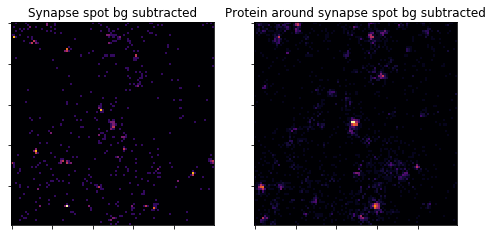

In [16]:
randomno=np.random.randint(1,len(df))
fig=plt.figure(figsize=(8,4))
fig.add_subplot(121)
plt.imshow(df["original_synapse_at_single_spot"][randomno],cmap='inferno')
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.gca().set(aspect='equal',adjustable='box')
plt.grid(False)
plt.title('Synapse spot bg subtracted')
fig.add_subplot(122)
plt.imshow(df["ecm_around_single_spot"][randomno],cmap='inferno')
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.gca().set(aspect='equal',adjustable='box')
plt.grid(False)
plt.title('Protein around synapse spot bg subtracted')

## Iterate over dataframe to add means normalized to median of experiment

In [17]:
df2=deepcopy(df)
df2=df2[df2["Exp"]!="Other Data"]
df2=df2[df2["Exp"]!="N0"]
df2=df2.reset_index(drop=True)

## Correlation of everything - quicklook

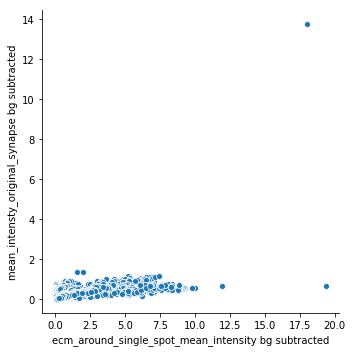

In [18]:
sns.relplot(x="ecm_around_single_spot_mean_intensity bg subtracted",
            y="mean_intensty_original_synapse bg subtracted",data=df2)

In [19]:
counter=1
for protein in df2["Protein"].unique():
    print(protein)
    dfprot=df2[df2["Protein"]==protein]
    dfprot=dfprot.reset_index()
    expnam=[]
    medtnr=[]
    medvglut=[]
    for exp in dfprot["Exp"].unique():
        dfexp=dfprot[dfprot["Exp"]==exp]
        med_tnr=dfexp["ecm_around_single_spot_mean_intensity bg subtracted"].median()
        med_vglut=dfexp["mean_intensty_original_synapse bg subtracted"].median()
        print(exp+' - med tnr: '+str(med_tnr)+' - med vglut: '+str(med_vglut))
        expnam.append(exp)
        medtnr.append(med_tnr)
        medvglut.append(med_vglut)
    dfprot["ecm mean int norm2med"]=np.nan
    dfprot["vglut mean int norm2med"]=np.nan
    for i in range(0,len(dfprot)):
        for j in range(0,len(expnam)):
            if dfprot["Exp"][i]==expnam[j]:
                dfprot["ecm mean int norm2med"][i]=dfprot["ecm_around_single_spot_mean_intensity bg subtracted"][i]/medtnr[j]
                dfprot["vglut mean int norm2med"][i]=dfprot["mean_intensty_original_synapse bg subtracted"][i]/medvglut[j]
    if counter==1:
        dfconcat=dfprot
        
    else:
        dfconcat=pd.concat([dfconcat,dfprot],axis=0,ignore_index=True)
    counter+=1

TGN38
N3 - med tnr: 1.0779712450002281 - med vglut: 0.5275603399992659
N4 - med tnr: 0.6581675600010057 - med vglut: 0.48643402999979807
N1 - med tnr: 0.4493171199992765 - med vglut: 0.4150899200009473
N2 - med tnr: 1.2857376000000047 - med vglut: 0.2373442299998045


/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ERGIC
N3 - med tnr: 3.8840386000002387 - med vglut: 0.514516319999413
N4 - med tnr: 0.7401282500004931 - med vglut: 0.5298402200003071
N1 - med tnr: 0.7595674300000995 - med vglut: 0.2030128000002078
N2 - med tnr: 1.4609082800011965 - med vglut: 0.25199180000029736
Synaptopodin
N3 - med tnr: 4.820410000001418 - med vglut: 0.6602916800007923
N4 - med tnr: 4.787703769999984 - med vglut: 0.8166792300004964
N1 - med tnr: 3.4046986850006107 - med vglut: 0.553441320000025
N2 - med tnr: 6.097411929998894 - med vglut: 0.47972063999951936
Calreticulin
N3 - med tnr: 0.6595746000004481 - med vglut: 0.2621979200006026
N4 - med tnr: 0.5626691100001346 - med vglut: 0.493289855000687
N1 - med tnr: 0.11229988999996748 - med vglut: 0.35790392999983234
N2 - med tnr: 0.44972206500001777 - med vglut: 0.09983735999986093


## Add fourier

In [20]:
dfconcat["ecm fourier"]=np.nan
for i in range(0,len(dfconcat)):
    fourier=np.fft.fft2(dfconcat["ecm_around_single_spot bg subtracted"][i])
    
    fourier=np.fft.fftshift(fourier)
    
    
    fourierval=np.abs(fourier[80:100,40:60]).mean()
    dfconcat["ecm fourier"][i]=fourierval

/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [ ]:
df2_backup=deepcopy(df2)

## Plot - loop over all proteins

In [20]:
vari="original_synapse_at_single_spot bg subtracted"
mini=1000
maxi=0
for i in range(0,len(df2)):
    if df2[vari][i].min()<mini:
        mini=df2[vari][i].min()
    if df2[vari][i].max()>maxi:
        maxi=df2[vari][i].max()
print(mini)
print(maxi)
scalefactor_vglut=65536/maxi
print(scalefactor_vglut)

0.0
794.7891000000018
82.45709459276662


In [21]:
vari="ecm_around_single_spot bg subtracted"
mini=1000
maxi=0
for i in range(0,len(df2)):
    if df2[vari][i].min()<mini:
        mini=df2[vari][i].min()
    if df2[vari][i].max()>maxi:
        maxi=df2[vari][i].max()
print(mini)
print(maxi)
scalefactor_protein=65536/maxi
print(scalefactor_protein)

0.0
980.1050000000032
66.86630514077551


/Users/taldankovich/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


<Figure size 432x288 with 0 Axes>

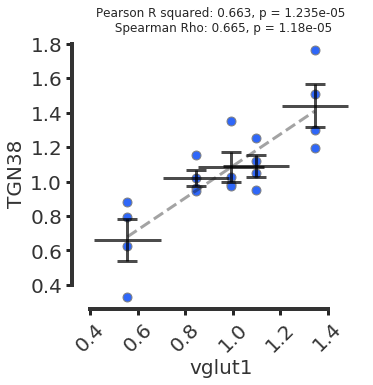

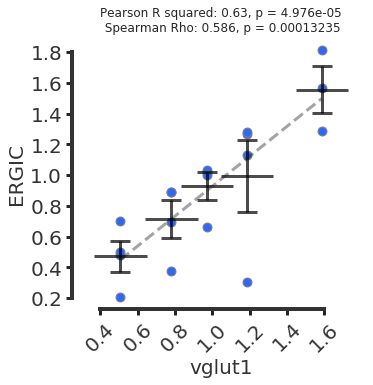

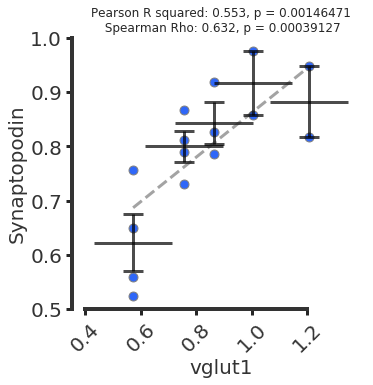

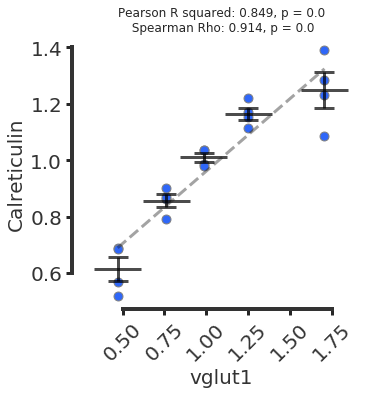

In [22]:
for protein in dfconcat["Protein"].unique():
    dfprot=dfconcat[dfconcat["Protein"]==protein]
    
    meani=dfprot["synapse size - no pixels in mask"].mean()
    stdi=dfprot["synapse size - no pixels in mask"].std()
    dfprot=dfprot[dfprot["synapse size - no pixels in mask"]<(meani+2.5*stdi)]
    
    meani=dfprot["vglut mean int norm2med"].mean()
    stdi=dfprot["vglut mean int norm2med"].std()
    dfprot=dfprot[dfprot["vglut mean int norm2med"]<(meani+3*stdi)]
    dfprot=dfprot[dfprot["vglut mean int norm2med"]>(meani-3*stdi)]
    
    meani=dfprot["ecm mean int norm2med"].mean()
    stdi=dfprot["ecm mean int norm2med"].std()
    dfprot=dfprot[dfprot["ecm mean int norm2med"]<(meani+3*stdi)]
    dfprot=dfprot[dfprot["ecm mean int norm2med"]>(meani-3*stdi)]
    
    #meani=dfprot["ecm fourier"].mean()
    #stdi=dfprot["ecm fourier"].std()
    dfprot=dfprot[dfprot["ecm fourier"]<300]
    #dfprot=dfprot[dfprot["ecm fourier"]>(meani-2.5*stdi)]
    
    meani=dfprot["mean phalloidin int"].mean()
    stdi=dfprot["mean phalloidin int"].std()
    dfprot=dfprot[dfprot["mean phalloidin int"]<(meani+2.5*stdi)]
    dfprot=dfprot[dfprot["mean phalloidin int"]>(meani-2.5*stdi)]
    
    dfprot=dfprot.sort_values("vglut mean int norm2med",ascending=True)
    dfprot=dfprot.reset_index(drop=True)
    #split into 5 separate dfs, add column with number
    a, b, c,d,e = np.split(dfprot, [int(.2*len(dfprot)),
                                    int(.4*len(dfprot)),int(.6*len(dfprot)),
                                    int(.8*len(dfprot))])
    a['Synapse mean intensity ordinal bin']=0
    b['Synapse mean intensity ordinal bin']=1
    c['Synapse mean intensity ordinal bin']=2
    d['Synapse mean intensity ordinal bin']=3
    e['Synapse mean intensity ordinal bin']=4
    #combine split dfs into one
    dfnew=pd.concat([a,b,c,d,e],axis=0,ignore_index=True)
    
    synapse_bin_type='Synapse mean intensity ordinal bin'
    means_in_bins_exps={"Exp name":[],"bin number":[],"mean vglut":[],"mean tnr":[],"number of spots":[],
                        "mean vglut int in bin overall":[]}
    for exp in dfnew["Exp"].unique():
        dfexp=dfnew[dfnew["Exp"]==exp]
        for i in range(0,5):       
            mean_in_bin=dfnew[dfnew[synapse_bin_type].astype(int)==i]["vglut mean int norm2med"].mean()
            #print(mean_in_bin)
            dfplot=dfexp[(dfexp[synapse_bin_type].astype(int)==i)]
            means_in_bins_exps["Exp name"].append(exp)
            means_in_bins_exps["bin number"].append(i)
            means_in_bins_exps["mean vglut int in bin overall"].append(mean_in_bin)
            means_in_bins_exps["mean vglut"].append(dfplot["vglut mean int norm2med"].mean())
            means_in_bins_exps["mean tnr"].append(dfplot["ecm mean int norm2med"].mean())
            nosynapses=len(dfplot)
            means_in_bins_exps["number of spots"].append(nosynapses)
    dfmeans=pd.DataFrame(means_in_bins_exps)
    
    #make average images
    for i in range(0,5):
        df2show=dfnew[dfnew["Synapse mean intensity ordinal bin"]==i]
        data=df2show["original_synapse_at_single_spot bg subtracted"].mean()
        data=data*scalefactor_vglut
        data=np.asarray(data,dtype=np.uint16)
        im = Image.fromarray(data)
        im.save(expdir[:-10]+'/Output_autospots/average_corr2vglut_vglut_image_'+protein+'_bin_'+str(i)+'.tiff')
        
        data=df2show["ecm_around_single_spot bg subtracted"].mean()
        data=data*scalefactor_protein
        data=np.asarray(data,dtype=np.uint16)
        im = Image.fromarray(data)
        im.save(expdir[:-10]+'/Output_autospots/average_corr2vglut_protein_image_'+protein+'_bin_'+str(i)+'.tiff')
        
   
    sns.set(font_scale=2.5)
    sns.set(font="Arial")
    sns.set_style("ticks")
    sns.despine()
    sns.set_palette("Set2")
    var="mean tnr"

    df2plot=dfmeans[dfmeans["Exp name"]!="Other Data"]

    fig=plt.figure(figsize=(5,5))
    g=sns.scatterplot(x="mean vglut int in bin overall",y="mean tnr",
                    data=df2plot,s=80,color="#2F67F8",linewidth=1,edgecolor='grey')

    plt.errorbar(x = df2plot["mean vglut int in bin overall"].unique()
    ,
                 y=[df2plot[df2plot["bin number"]==0][var].mean(),
                    df2plot[df2plot["bin number"]==1][var].mean(),
                    df2plot[df2plot["bin number"]==2][var].mean(),
                    df2plot[df2plot["bin number"]==3][var].mean(),
                    df2plot[df2plot["bin number"]==4][var].mean()],
                 yerr=[df2plot[df2plot["bin number"]==0][var].sem(),
                       df2plot[df2plot["bin number"]==1][var].sem(),
                       df2plot[df2plot["bin number"]==2][var].sem(),
                       df2plot[df2plot["bin number"]==3][var].sem(),
                       df2plot[df2plot["bin number"]==4][var].sem()],
                 xerr=None,ecolor='black',fmt='none',capsize=10,linewidth=3,capthick=3,alpha=.7,)

    plt.errorbar(x = df2plot["mean vglut int in bin overall"].unique()
    ,
                 y=[df2plot[df2plot["bin number"]==0][var].mean(),
                    df2plot[df2plot["bin number"]==1][var].mean(),
                    df2plot[df2plot["bin number"]==2][var].mean(),
                    df2plot[df2plot["bin number"]==3][var].mean(),
                    df2plot[df2plot["bin number"]==4][var].mean()],
                 yerr=None,
                 xerr=[.14,.14,.14,.14,.14],ecolor='black',fmt='none',capsize=0,linewidth=3,capthick=3,alpha=.7,)


    from math import ceil, floor
    def float_round(num, places = 0, direction = floor):
        return direction(num * (10**places)) / float(10**places)

    plt.rcParams['font.sans-serif'] = 'Helvetica'
    g.grid(False)
    #plt.ylim([0,1.5])
    #plt.xlim([.2,2.8])

    #fit linear curve
    dfnonans=df2plot.dropna()
    x=dfnonans["mean vglut int in bin overall"].unique()
    y=dfnonans.groupby("mean vglut int in bin overall").mean()["mean tnr"].values
    m,b = np.polyfit(x, y, 1) 
    plt.plot( x, m*x+b, 'k',linestyle='dashed',alpha=.4,linewidth=3) 

    from pydoc import help
    from scipy.stats.stats import pearsonr, spearmanr
    [pearson, pval]=pearsonr(dfnonans["mean tnr"],dfnonans["mean vglut int in bin overall"])
    [spearman, pval2]=spearmanr(dfnonans["mean tnr"],dfnonans["mean vglut int in bin overall"])

    pearsonr=float_round(pearson**2,3)
    pval=float_round(pval,8)
    spearmanr=float_round(spearman**2,3)
    pval2=float_round(pval2,8)
    #print(str(pearson**2))
    #print(pval)

    #formatting
    g.xaxis.set_tick_params(width=3)
    g.yaxis.set_tick_params(width=3)
    for axis in ['top','bottom','left','right']:
      g.spines[axis].set_linewidth(4)
      g.spines[axis].set_color('#333333')
      g.spines[axis].set_alpha(1)
    offsets={"left":10,"bottom":0}
    trims={"left":True,"bottom":True,"right":False}
    sns.despine(ax=g,right=True,top=True,bottom=False,trim=trims,offset=offsets)
    g.set_ylabel(protein,color='#333333',size=20)
    g.set_xlabel('vglut1',color='#333333',size=20)
    plt.yticks(g.get_yticks(),color='#333333',size=20)
    plt.xticks(g.get_xticks(),color='#333333',size=20,rotation=45)
    plt.title('Pearson R squared: '+str(pearsonr)+', p = '+str(pval)+'\n Spearman Rho: '+str(spearmanr)
             +', p = '+str(pval2))

    dfmeans.to_csv(expdir[:-10]+'/Output_autospots/corr2vglut_means_'+protein+'.csv')
    fig.savefig(expdir[:-10]+'/Output_autospots/corr2vglut_plot_'+protein+'.eps')

Text(0.5, 0, '')

<Figure size 432x288 with 0 Axes>

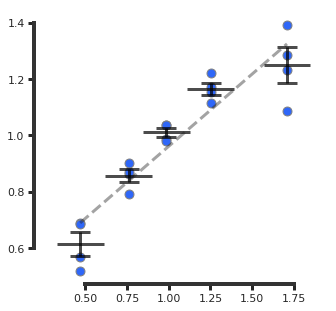

In [23]:
sns.set(font_scale=2.5)
sns.set(font="Arial")
sns.set_style("ticks")
sns.despine()
sns.set_palette("Set2")
var="mean tnr"

df2plot=dfmeans#[dfmeans["Exp name"]!="Other Data"]

fig=plt.figure(figsize=(5,5))
g=sns.scatterplot(x="mean vglut int in bin overall",y="mean tnr",
                data=df2plot,s=80,color="#2F67F8",linewidth=1,edgecolor='grey')

plt.errorbar(x = df2plot["mean vglut int in bin overall"].unique()
,
             y=[df2plot[df2plot["bin number"]==0][var].mean(),
                df2plot[df2plot["bin number"]==1][var].mean(),
                df2plot[df2plot["bin number"]==2][var].mean(),
                df2plot[df2plot["bin number"]==3][var].mean(),
                df2plot[df2plot["bin number"]==4][var].mean()],
             yerr=[df2plot[df2plot["bin number"]==0][var].sem(),
                   df2plot[df2plot["bin number"]==1][var].sem(),
                   df2plot[df2plot["bin number"]==2][var].sem(),
                   df2plot[df2plot["bin number"]==3][var].sem(),
                   df2plot[df2plot["bin number"]==4][var].sem()],
             xerr=None,ecolor='black',fmt='none',capsize=10,linewidth=3,capthick=3,alpha=.7,)

plt.errorbar(x = df2plot["mean vglut int in bin overall"].unique()
,
             y=[df2plot[df2plot["bin number"]==0][var].mean(),
                df2plot[df2plot["bin number"]==1][var].mean(),
                df2plot[df2plot["bin number"]==2][var].mean(),
                df2plot[df2plot["bin number"]==3][var].mean(),
                df2plot[df2plot["bin number"]==4][var].mean()],
             yerr=None,
             xerr=[.14,.14,.14,.14,.14],ecolor='black',fmt='none',capsize=0,linewidth=3,capthick=3,alpha=.7,)


plt.rcParams['font.sans-serif'] = 'Helvetica'
g.grid(False)
#plt.ylim([0.55,1.3])
#plt.xlim([.2,2.8])

#fit linear curve
dfnonans=df2plot.dropna()
x=dfnonans["mean vglut int in bin overall"].unique()
y=dfnonans.groupby("mean vglut int in bin overall").mean()["mean tnr"].values
m,b = np.polyfit(x, y, 1) 
plt.plot( x, m*x+b, 'k',linestyle='dashed',alpha=.4,linewidth=3) 

#formatting
g.xaxis.set_tick_params(width=3)
g.yaxis.set_tick_params(width=3)
for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(4)
  g.spines[axis].set_color('#333333')
  g.spines[axis].set_alpha(1)
offsets={"left":10,"bottom":0}
trims={"left":True,"bottom":True,"right":False}
sns.despine(ax=g,right=True,top=True,bottom=False,trim=trims,offset=offsets)
g.set_ylabel('')
g.set_xlabel('')
#plt.yticks([0.7,0.9,1.1,1.3],color='#333333',size=20)
#plt.xticks([0.4, 0.7, 1. , 1.4, 2.6],color='#333333',size=20,rotation=45)


#diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"
#fig.savefig(diri+'3b_tnrvglutcorr.svg', bbox_inches='tight', format='svg')

## Calculate the Pearson's R and significance

In [37]:
from pydoc import help
from scipy.stats.stats import pearsonr
[pearson, pval]=pearsonr(dfnonans["mean tnr"],dfnonans["mean vglut int in bin overall"])
print(str(pearson**2))
print(pval)

0.628198145770871
1.0940102041160712e-05


## Plot exps separately

<Figure size 432x288 with 0 Axes>

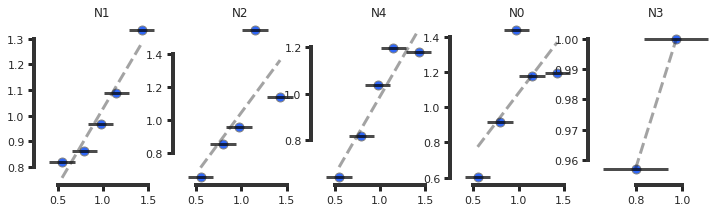

In [183]:
sns.set(font_scale=2.5)
sns.set(font="Arial")
sns.set_style("ticks")
sns.despine()
sns.set_palette("Set2")
var="mean tnr"
fig=plt.figure(figsize=(12,3))
count=0
for exp in dfmeans["Exp name"].unique():
    count+=1
    fig.add_subplot(1,5,count)
    plt.title(exp)


    df2plot=dfmeans[dfmeans["Exp name"]==exp]
    g=sns.scatterplot(x="mean vglut int in bin overall",y="mean tnr",
                    data=df2plot,s=80,color="#2F67F8",linewidth=1,edgecolor='grey')

    plt.errorbar(x = df2plot["mean vglut int in bin overall"].unique()
    ,
                 y=[df2plot[df2plot["bin number"]==0][var].mean(),
                    df2plot[df2plot["bin number"]==1][var].mean(),
                    df2plot[df2plot["bin number"]==2][var].mean(),
                    df2plot[df2plot["bin number"]==3][var].mean(),
                    df2plot[df2plot["bin number"]==4][var].mean()],
                 yerr=[df2plot[df2plot["bin number"]==0][var].sem(),
                       df2plot[df2plot["bin number"]==1][var].sem(),
                       df2plot[df2plot["bin number"]==2][var].sem(),
                       df2plot[df2plot["bin number"]==3][var].sem(),
                       df2plot[df2plot["bin number"]==4][var].sem()],
                 xerr=None,ecolor='black',fmt='none',capsize=10,linewidth=3,capthick=3,alpha=.7,)

    plt.errorbar(x = df2plot["mean vglut int in bin overall"].unique()
    ,
                 y=[df2plot[df2plot["bin number"]==0][var].mean(),
                    df2plot[df2plot["bin number"]==1][var].mean(),
                    df2plot[df2plot["bin number"]==2][var].mean(),
                    df2plot[df2plot["bin number"]==3][var].mean(),
                    df2plot[df2plot["bin number"]==4][var].mean()],
                 yerr=None,
                 xerr=[.14,.14,.14,.14,.14],ecolor='black',fmt='none',capsize=0,linewidth=3,capthick=3,alpha=.7,)


    plt.rcParams['font.sans-serif'] = 'Helvetica'
    g.grid(False)
    #plt.ylim([0.55,1.3])
    #plt.xlim([.2,2.8])

    #fit linear curve
    
    dfnonans=df2plot.dropna()
    x=dfnonans["mean vglut int in bin overall"].unique()
    y=dfnonans.groupby("mean vglut int in bin overall").mean()["mean tnr"].values
    m,b = np.polyfit(x, y, 1) 
    plt.plot( x, m*x+b, 'k',linestyle='dashed',alpha=.4,linewidth=3) 

    #formatting
    g.xaxis.set_tick_params(width=3)
    g.yaxis.set_tick_params(width=3)
    for axis in ['top','bottom','left','right']:
      g.spines[axis].set_linewidth(4)
      g.spines[axis].set_color('#333333')
      g.spines[axis].set_alpha(1)
    offsets={"left":10,"bottom":0}
    trims={"left":True,"bottom":True,"right":False}
    sns.despine(ax=g,right=True,top=True,bottom=False,trim=trims,offset=offsets)
    g.set_ylabel('')
    g.set_xlabel('')
    #plt.yticks([0.7,0.9,1.1,1.3],color='#333333',size=20)
    #plt.xticks([0.4, 0.7, 1. , 1.4, 2.6],color='#333333',size=20,rotation=45)


    diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"
    fig.savefig(diri+'3b_tnrvglutcorr.svg', bbox_inches='tight', format='svg')

## Try a different fit

Text(0.5, 0, '')

/Users/taldankovich/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


<Figure size 432x288 with 0 Axes>

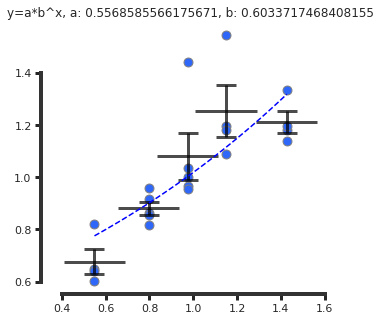

In [38]:
sns.set(font_scale=2.5)
sns.set(font="Arial")
sns.set_style("ticks")
sns.despine()
sns.set_palette("Set2")
var="mean tnr"

df2plot=dfmeans#[dfmeans["Exp name"]!="Other Data"]

fig=plt.figure(figsize=(5,5))
g=sns.scatterplot(x="mean vglut int in bin overall",y="mean tnr",
                data=df2plot,s=80,color="#2F67F8",linewidth=1,edgecolor='grey')

plt.errorbar(x = df2plot["mean vglut int in bin overall"].unique()
,
             y=[df2plot[df2plot["bin number"]==0][var].mean(),
                df2plot[df2plot["bin number"]==1][var].mean(),
                df2plot[df2plot["bin number"]==2][var].mean(),
                df2plot[df2plot["bin number"]==3][var].mean(),
                df2plot[df2plot["bin number"]==4][var].mean()],
             yerr=[df2plot[df2plot["bin number"]==0][var].sem(),
                   df2plot[df2plot["bin number"]==1][var].sem(),
                   df2plot[df2plot["bin number"]==2][var].sem(),
                   df2plot[df2plot["bin number"]==3][var].sem(),
                   df2plot[df2plot["bin number"]==4][var].sem()],
             xerr=None,ecolor='black',fmt='none',capsize=10,linewidth=3,capthick=3,alpha=.7,)

plt.errorbar(x = df2plot["mean vglut int in bin overall"].unique()
,
             y=[df2plot[df2plot["bin number"]==0][var].mean(),
                df2plot[df2plot["bin number"]==1][var].mean(),
                df2plot[df2plot["bin number"]==2][var].mean(),
                df2plot[df2plot["bin number"]==3][var].mean(),
                df2plot[df2plot["bin number"]==4][var].mean()],
             yerr=None,
             xerr=[.14,.14,.14,.14,.14],ecolor='black',fmt='none',capsize=0,linewidth=3,capthick=3,alpha=.7,)


plt.rcParams['font.sans-serif'] = 'Helvetica'
g.grid(False)
#plt.ylim([0.55,1.3])
#plt.xlim([.2,2.8])

#fit linear curve
dfnonans=df2plot.dropna()
x=dfnonans["mean vglut int in bin overall"].unique()
y=dfnonans.groupby("mean vglut int in bin overall").mean()["mean tnr"].values
m,b = np.polyfit(x, y, 1) 
#plt.plot( x, m*x+b, 'k',linestyle='dashed',alpha=.4,linewidth=3) 

#power of 2 fit
a,b,c = np.polyfit(x, y, 2) 
new_x = np.linspace(x[0], x[-1])
#plt.plot( new_x, a*new_x**2+b*new_x+c, 'k',linestyle='dashed',alpha=.4,linewidth=3) 
#print('y=a*x^2 + b, a: '+str(m)+', b: '+str(b))


#exponential fit
from scipy.optimize import curve_fit 
def test(x, a, b): 
    return a*np.exp(b*x)
param, param_cov = curve_fit(test, x, y)
ans = (param[0]*(np.exp(param[1]*new_x))) 
plt.plot(new_x, ans, '--', color ='blue', label ="optimized data") 
plt.title('y=a*b^x, a: '+str(param[0])+', b: '+str(param[1]))

#formatting
g.xaxis.set_tick_params(width=3)
g.yaxis.set_tick_params(width=3)
for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(4)
  g.spines[axis].set_color('#333333')
  g.spines[axis].set_alpha(1)
offsets={"left":10,"bottom":0}
trims={"left":True,"bottom":True,"right":False}
sns.despine(ax=g,right=True,top=True,bottom=False,trim=trims,offset=offsets)
g.set_ylabel('')
g.set_xlabel('')
#plt.yticks([0.7,0.9,1.1,1.3],color='#333333',size=20)
#plt.xticks([0.4, 0.7, 1. , 1.4, 2.6],color='#333333',size=20,rotation=45)


#diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"
#fig.savefig(diri+'3b_tnrvglutcorr.svg', bbox_inches='tight', format='svg')

## No. synapses in each bin

In [185]:
for bin in dfnew["Synapse mean intensity ordinal bin"].unique():
    print(len(dfnew[dfnew["Synapse mean intensity ordinal bin"]==bin]))

172
172
172
172
173


## Plot single synapse from each bin

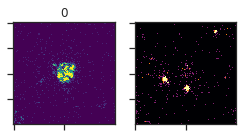

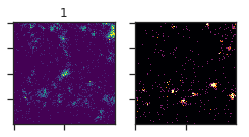

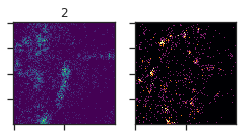

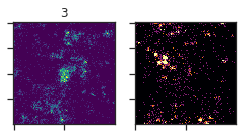

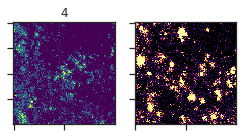

In [188]:

for i in range(0,5):
    df2show=dfnew[dfnew["Synapse mean intensity ordinal bin"]==i]
    df2show=df2show.reset_index(drop=True)
    randomno=np.random.randint(1,len(df2show))
    
    fig=plt.figure(figsize=(4,2))
    fig.add_subplot(121)
    plt.title(i)
    plt.imshow(df2show["original_synapse_at_single_spot bg subtracted"][randomno],cmap='viridis',
               vmin=0.1*np.min(dfnew["original_synapse_at_single_spot bg subtracted"].mean()),
               vmax=1.5*np.max(dfnew["original_synapse_at_single_spot bg subtracted"].mean()))
    plt.xticks(visible=False)
    plt.yticks(visible=False)
    plt.gca().set(aspect='equal',adjustable='box')
    plt.grid(False)
    #plt.title('Synapse spot bg subtracted')
    fig.add_subplot(122)
    plt.imshow(df2show["ecm_around_single_spot bg subtracted"][randomno],cmap='inferno',
               vmin=0.02*np.min(dfnew["ecm_around_single_spot bg subtracted"].mean()),
               vmax=0.8*np.max(dfnew["ecm_around_single_spot bg subtracted"].mean()))
    plt.xticks(visible=False)
    plt.yticks(visible=False)
    plt.gca().set(aspect='equal',adjustable='box')
    plt.grid(False)
    #plt.title('Protein around synapse spot bg subtracted')

## Plot mean synapse from each bin

0.0009782740629270886
0.001548745702689767
0.0020662605658910075
0.002258803337436924
0.002611736571460254


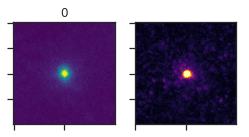

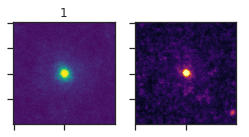

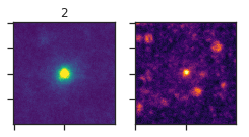

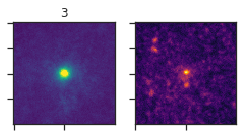

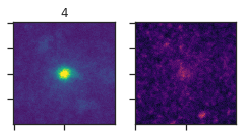

In [39]:

for i in range(5):
    df2show=dfnew[dfnew["Synapse mean intensity ordinal bin"]==i]
    df2show=df2show.reset_index(drop=True)
    print(df2show["original_synapse_at_single_spot bg subtracted"].mean().mean())
    fig=plt.figure(figsize=(4,2))
    fig.add_subplot(121)
    plt.title(i)
    plt.imshow(df2show["original_synapse_at_single_spot bg subtracted"].mean(),cmap='viridis',
               vmin=0.02*np.min(dfnew["original_synapse_at_single_spot bg subtracted"].mean()),
               vmax=0.8*np.max(dfnew["original_synapse_at_single_spot bg subtracted"].mean()))
    plt.xticks(visible=False)
    plt.yticks(visible=False)
    plt.gca().set(aspect='equal',adjustable='box')
    plt.grid(False)
    #plt.title('Synapse spot bg subtracted')
    fig.add_subplot(122)
    plt.imshow(df2show["ecm_around_single_spot bg subtracted"].mean(),cmap='inferno',
               vmin=0.02*np.min(dfnew["ecm_around_single_spot bg subtracted"].mean()),
               vmax=0.8*np.max(dfnew["ecm_around_single_spot bg subtracted"].mean()))
    plt.xticks(visible=False)
    plt.yticks(visible=False)
    plt.gca().set(aspect='equal',adjustable='box')
    plt.grid(False)
    #plt.title('Protein around synapse spot bg subtracted')